# Project Description

**Create a 4D dataset of 3D sub-volumes from a dense EM volume as well as the corresponding GT sag.mask sub-volume dataset.**

The notebook works through the following steps:

* Apply a 3D center crop to the 3D data, segmentations, and masks
* Apply the masks to the data to crop out the background
* Upsample the croped and masked data, as well as the GT segmenations, along x-y plane.
* Store the croped, masked, and upsampled data, as well as the segmentatios, as 3D arrays
* Split the saved 3D volumes in to sub-volumes
* Saver the sub-volumes to two different tiffi files

# Imports

In [1]:
# image manipulation
import cv2
import numpy as np
from PIL import Image
from skimage.transform import resize
from scipy.ndimage import zoom

# data format handling
import tifffile
import h5py

# utility, visualization, and path handling 
from tqdm import tqdm
from glob import glob
from matplotlib import pyplot as plt

# system configurations handling
from yacs.config import CfgNode as CN

# 3D tensor handling
import torch
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

import csv
from shutil import copyfile
import os

# System configurations

In [2]:
_C = CN()

_C.H5IMGS = '/n/pfister_lab2/Lab/zudilin/data/NucExM/NucExM-Release/downsampled/image4_ds_4x.h5'

_C.SAVEB_TRAIN = '/n/pfister_lab2/Lab/leander/em2exm/ccgan/datasets/submission_vol4_255_512/trainB/'
_C.SAVEB_TEST = '/n/pfister_lab2/Lab/leander/em2exm/ccgan/datasets/submission_vol4_255_512/testB/'

_C.BLOCKSIZE = (17, 65, 65) # the size of the sub-volumes
_C.SCALE = [0.25,0.25] # the rate by which the data is scaled
_C.IMG_SHAPE = (2048, 2048) # height and widht of the data
_C.IMG_LEN = 255 # depth of the data or rather number of slices

_C.D_BOUND_0 = 0
_C.D_BOUND_1 = 255
_C.H_BOUND_0 = 0
_C.H_BOUND_1 = 2048
_C.W_BOUND_0 = 0
_C.W_BOUND_1 = 2048

_C.TARGET_SIZE = (255,512,512)


def get_cfg_defaults():
  """Get a yacs CfgNode object with default values for my_project."""
  # Return a clone so that the defaults will not be altered
  # This is for the "local variable" use pattern
  return _C.clone()

cfg = get_cfg_defaults()
#cfg.merge_from_file("./configs/base_setup.yaml")
cfg.freeze()

# Data

#### Patch the images

In [3]:
import os 
try:
    os.makedirs(cfg.SAVEB_TRAIN, exist_ok=False)
except FileExistsError as e:
    print(e)
    
import os 
try:
    os.makedirs(cfg.SAVEB_TEST, exist_ok=False)
except FileExistsError as e:
    print(e)

In [10]:
# open the source files for reading
with h5py.File(cfg.H5IMGS, 'r') as hdf_dorsal:
        
    # get the masks
    hdf_dorsal_keys = list(hdf_dorsal.keys()) # prints ['main']
    hdf_dors = hdf_dorsal.get(hdf_dorsal_keys[0])

    images = np.asarray(hdf_dors)
    
    # crop volume
    images_croped = images[cfg.D_BOUND_0:cfg.D_BOUND_1,cfg.H_BOUND_0:cfg.H_BOUND_1,cfg.H_BOUND_0:cfg.H_BOUND_1]

    final_image_volume = np.zeros(cfg.TARGET_SIZE).astype(np.uint8)
    
    
    assert(images_croped.shape == (255, 2048, 2048)), f"the actual shape is {final_image_volume.shape}"

    # preprocess the images: discard outer sclices, mask, zoom
    # iterate over the images and their corresponding names
    for i, img in tqdm(enumerate(images_croped)):            

        # 2. Upsample the image and GT mask
        # use bilinear upsampling for the images
        img = resize(img, cfg.TARGET_SIZE[1:], order=3, preserve_range=True, anti_aliasing=True)

        assert(img.shape == cfg.TARGET_SIZE[1:]), f"the actual shape is {img.shape}"

        final_image_volume[i, :, :] = img
            
    assert(final_image_volume.shape == cfg.TARGET_SIZE), f"the actual shape is {final_image_volume.shape}"

    final_image_volume = (((final_image_volume - np.min(final_image_volume)) / float(np.max(final_image_volume)-np.min(final_image_volume))) * 255).astype(np.uint8)

    print(np.max(final_image_volume),np.min(final_image_volume))
    img_tif_name = 'exm_3D_255_512_512.tif'
    print(os.path.join(cfg.SAVEB_TRAIN, img_tif_name))
    print(os.path.join(cfg.SAVEB_TEST, img_tif_name))
    tifffile.imsave(os.path.join(cfg.SAVEB_TRAIN, img_tif_name), final_image_volume)
    tifffile.imsave(os.path.join(cfg.SAVEB_TEST, img_tif_name), final_image_volume)
   

20it [00:00, 202.39it/s]


(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)


In [11]:
with tifffile.TiffFile("/n/pfister_lab2/Lab/leander/cerberus/ccgan/datasets/dorsal_crop_3D_255_512/trainB/exm_3D_255_512_512.tif") as train, \
     tifffile.TiffFile("/n/pfister_lab2/Lab/leander/cerberus/ccgan/datasets/dorsal_crop_3D_255_512/testB/exm_3D_255_512_512.tif") as test:
    train = np.asarray([e.asarray() for e in train.pages[:]])
    test = np.asarray([e.asarray() for e in test.pages[:]])

    assert(train.dtype == "uint8"), "The input image volume should be of type uint8"
    assert(test.dtype == "uint8"), "The input image volume should be of type uint8"
    
    assert(train.shape == (255,512,512)), "The input image volume most have shape (255,512,512)"
    assert(test.shape == (255,512,512)), "The input image volume most have shape (255,512,512)"
    
    print("All good!")

All good!


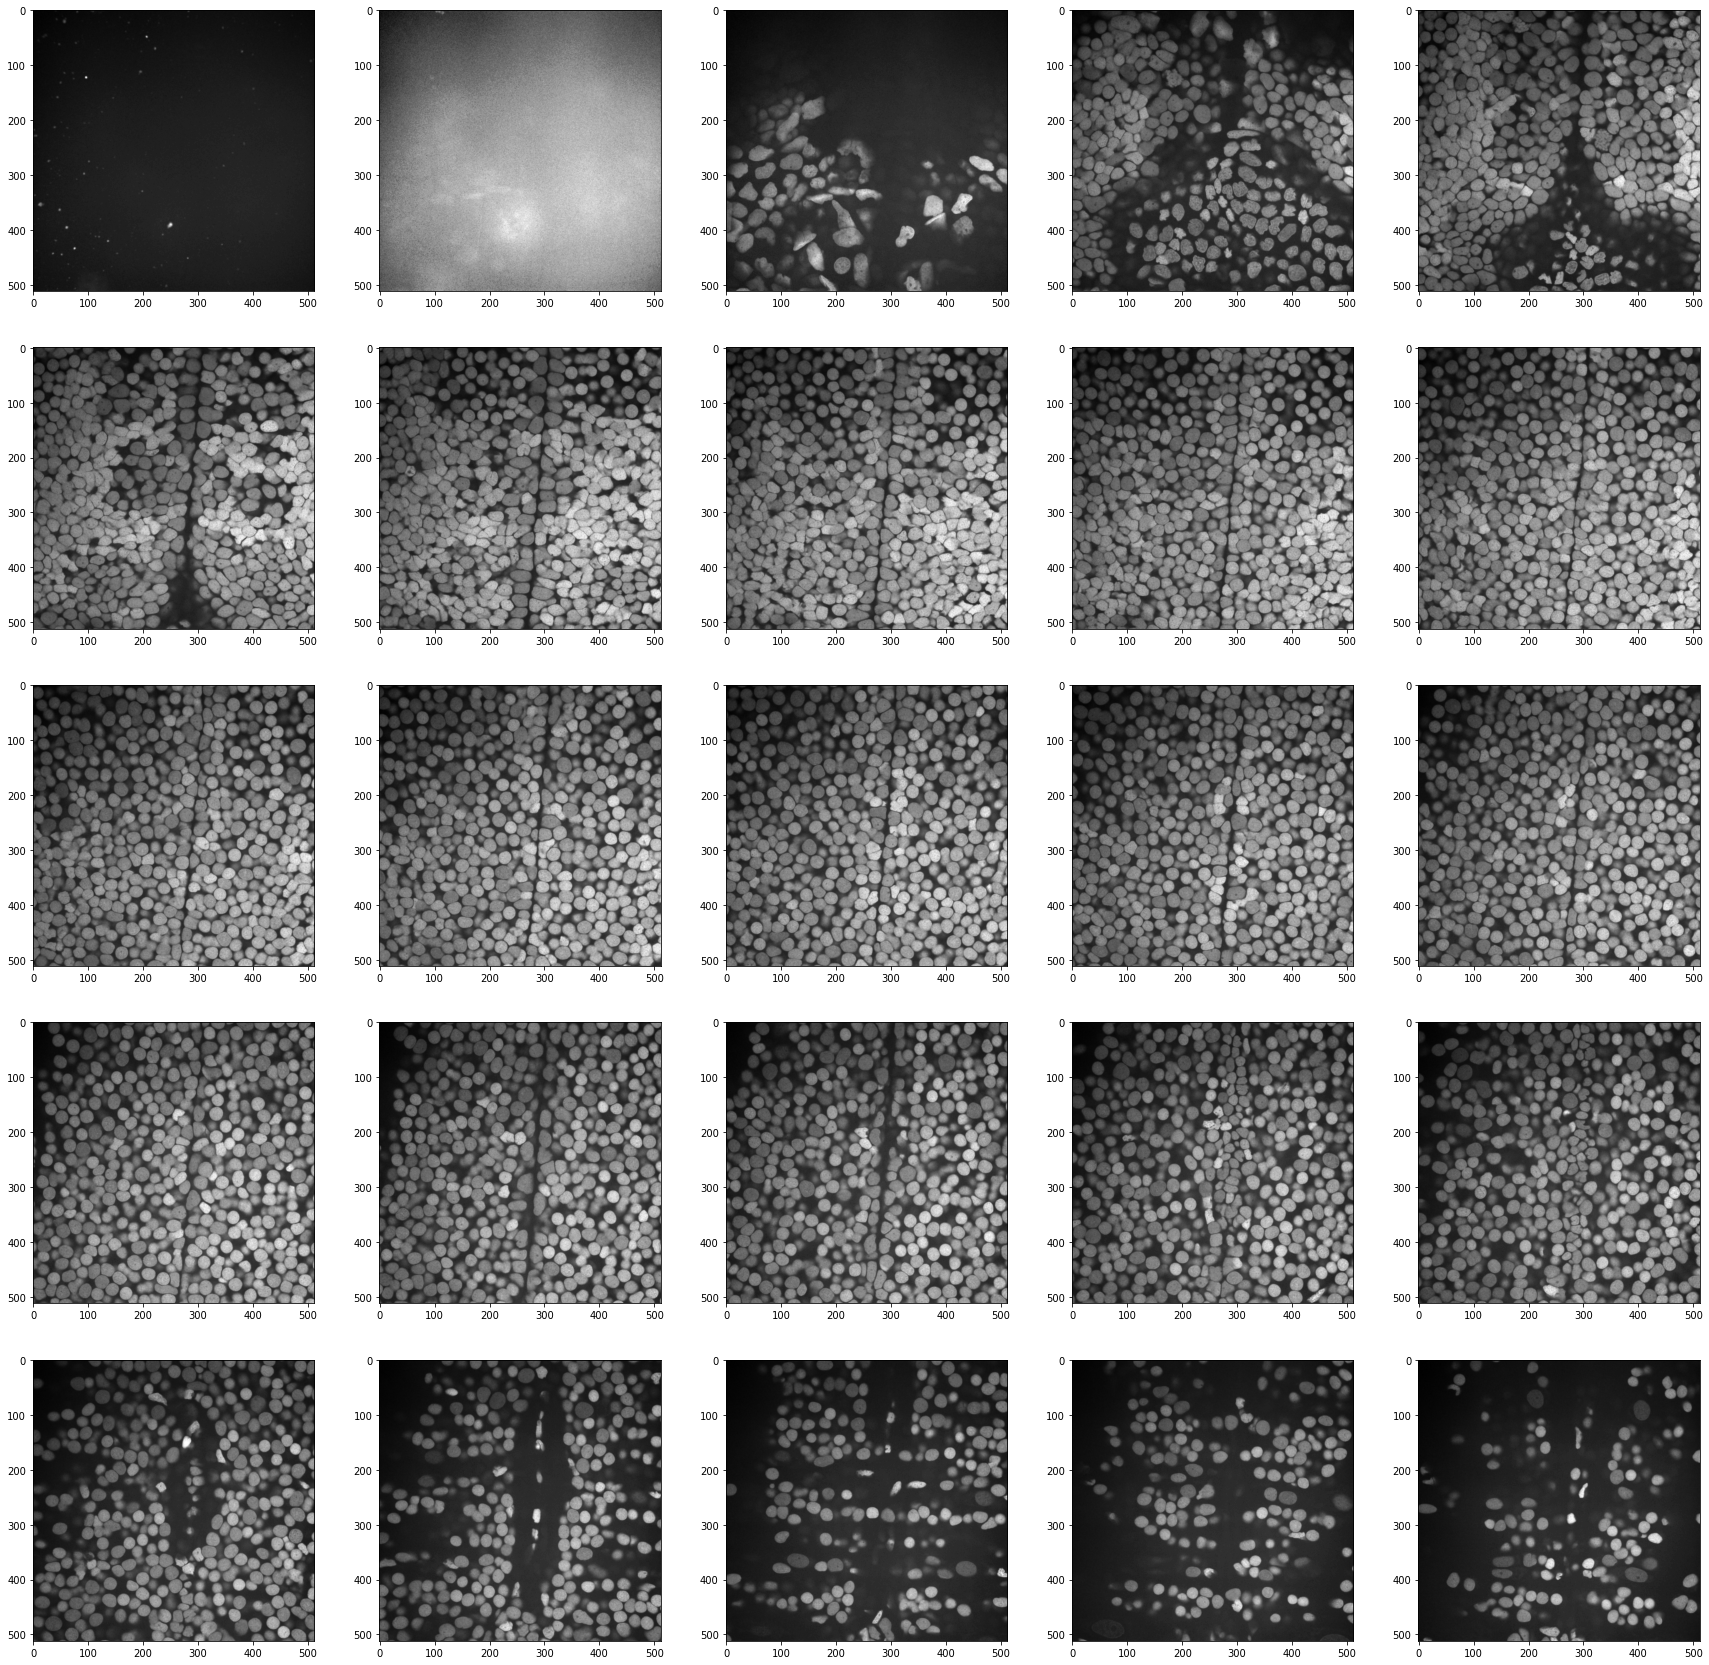

In [12]:
with tifffile.TiffFile("/n/pfister_lab2/Lab/leander/cerberus/ccgan/datasets/dorsal_crop_3D_255_512/trainB/exm_3D_255_512_512.tif") as tif:
    images = np.asarray([img.asarray() for img in tif.pages[:]])
    
    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(30,30))
    plt.set_cmap('gray')

    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i*10,:,:])
